In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm, decomposition, tree
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import torch

import pickle

import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

### Загружаем датасет для прогноза соотношения матрица-наполнитель

In [2]:
data_norm = pd.read_excel('data_norm.xlsx')
data_norm.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data_norm.shape

(1000, 13)

In [3]:
X = data_norm.drop(columns=['Модуль_упругости_при_растяжении_ГПа',
                            'Прочность_при_растяжении_МПа',
                            'Соотношение_матрица_наполнитель'], axis=1)
y_mat = data_norm['Соотношение_матрица_наполнитель']
x_train_mat, x_test_mat, y_train_mat, y_test_mat = train_test_split(X, y_mat, test_size=0.3)
x_train_mat.shape, x_test_mat.shape, y_train_mat.shape, y_test_mat.shape

((700, 10), (300, 10), (700,), (300,))

### Загружаем датасет для прогноза соотношения матрица-наполнитель, состояший из 6-ти главных коппонент

In [4]:
data_decomp = pd.read_excel('data_decomp.xlsx')
data_decomp.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data_decomp

,1_комп,2_комп,3_комп,4_комп,5_комп,6_комп,Соотношение_матрица_наполнитель
0,-0.508828,-0.248550,0.041193,-0.244357,0.169834,0.057408,0.282131
1,-0.508550,-0.167435,-0.007079,-0.050986,-0.108076,0.151275,0.282131
2,-0.504939,-0.193496,-0.012111,-0.124619,-0.008181,0.119009,0.457857
3,-0.501708,-0.201938,-0.015913,-0.085253,-0.016315,0.099312,0.457201
4,-0.492169,-0.227888,-0.072994,0.028262,-0.034789,0.035149,0.419084
...,...,...,...,...,...,...,...
995,0.492764,-0.205379,-0.084443,0.070066,-0.121624,-0.209612,0.361750
996,0.502932,-0.055423,0.172960,-0.100756,-0.174906,-0.181884,0.587163
997,0.515106,0.142535,0.188758,-0.141868,0.130638,0.089445,0.555750
998,0.503619,0.146061,-0.036864,-0.212746,-0.204659,0.031840,0.637396


In [5]:
X_dec = data_decomp.drop(columns=['Соотношение_матрица_наполнитель'], axis=1)
y_mat = data_decomp['Соотношение_матрица_наполнитель']
x_train_decomp, x_test_decomp, y_train_decomp, y_test_decomp = train_test_split(X_dec, y_mat, test_size=0.3)
x_train_decomp.shape, x_test_decomp.shape, y_train_decomp.shape, y_test_decomp.shape

((700, 6), (300, 6), (700,), (300,))

___

# Нейронные сети

In [6]:
# функция для отрисовки графика ошибки

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [7]:
# функция для компиляции, записи истории и выведения графика ошибки

def history_plot(model, x_train, y_train, epoch=20):
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  loss='mean_absolute_error')
    history = model.fit(x_train, y_train,
                        epochs=epoch,
                        verbose=0,
                        validation_split=0.1)

    plot_loss(history)

In [8]:
test_results = {}

### Линейная модель от `поверхностной плотности` (однослойный перцептрон)

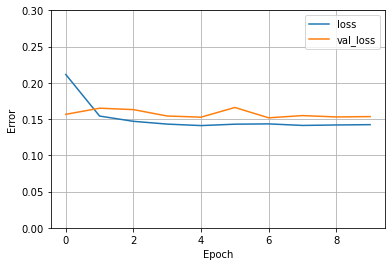

In [9]:
pov_plotn_model = tf.keras.Sequential([layers.Dense(units=1)])
history_plot(pov_plotn_model, x_train_mat['Поверхностная_плотность_г_м2'], y_train_mat, epoch=10)
test_results['Поверхностная_плотность, 1 слой'] = pov_plotn_model.evaluate(x_test_mat['Поверхностная_плотность_г_м2'],
                                                                  y_test_mat,
                                                                  verbose=0)

In [10]:
x = tf.linspace(0.0, 1, 500)
y = pov_plotn_model.predict(x)

16/16 [==============================] - 0s 2ms/step


In [11]:
def plot_pov_plot(x, y):
  plt.scatter(data_norm['Поверхностная_плотность_г_м2'], y_mat, label='Data')
  plt.plot(x, y, color='k', label='Prediction')
  plt.xlabel('Поверхностная_плотность_г_м2')
  plt.ylabel('Соотношение_матрица_наполнитель')
  plt.legend()

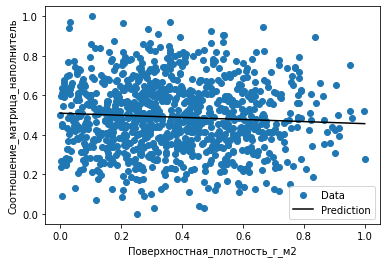

In [12]:
plot_pov_plot(x, y)

### Линейная модель от всех признаков (однослойный перцептрон)

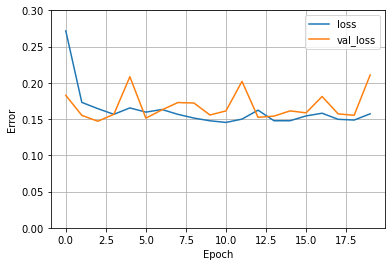

In [13]:
linear_model = tf.keras.Sequential([layers.Dense(units=1)])

history_plot(linear_model, x_train_mat, y_train_mat)
test_results['Линейная модель, 1 слой'] = linear_model.evaluate(x_test_mat,
                                                                 y_test_mat,
                                                                 verbose=0)

### Линейная модель от главных компонент (однослойный перцептрон)

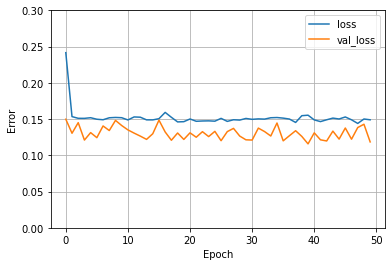

In [38]:
linear_model_dec = tf.keras.Sequential([layers.Dense(units=1)])

history_plot(linear_model_dec, x_train_decomp, y_train_decomp, epoch=50)
test_results['Линейная модель, 1 слой (компоненты)'] = linear_model_dec.evaluate(x_test_decomp,
                                                                     y_test_decomp,
                                                                     verbose=0)

# Многослойный перцептрон
### модель от `поверхностной плотности`

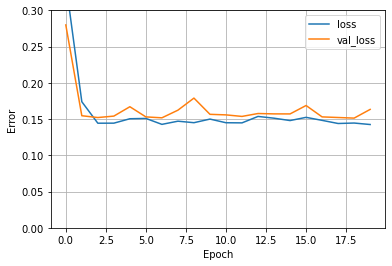

In [15]:
pov_plot_2 = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                               layers.Dense(1, activation='linear')])
  
history_plot(pov_plot_2, x_train_mat['Поверхностная_плотность_г_м2'], y_train_mat)
test_results['Поверхностная_плотность, 2 слоя'] = pov_plot_2.evaluate(x_test_mat['Поверхностная_плотность_г_м2'],
                                                                        y_test_mat,
                                                                        verbose=0)

## Многослойный перцептрон от всех признаков
#### Модель: 2 слоя, 10 нейронов, активационная функция - сигмоида

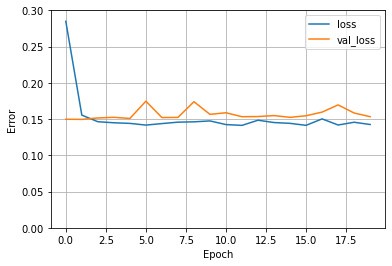

In [16]:
model_2l_10_sigm = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                    layers.Dense(1, activation='linear')])
  
history_plot(model_2l_10_sigm, x_train_mat, y_train_mat)
test_results['2 слоя, 10 нейр., сигмоида'] = model_2l_10_sigm.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 2сл., 10 нейр., сигмоида (компоненты)

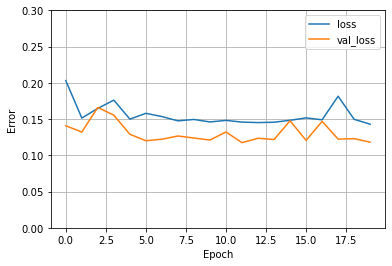

In [17]:
model_2l_10_sigm_dec = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                        layers.Dense(1, activation='linear')])

history_plot(model_2l_10_sigm_dec, x_train_decomp, y_train_decomp)
test_results['2 слоя, 10 нейр., сигмоида (компоненты)'] = model_2l_10_sigm_dec.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

#### Модель: 2 сл. с 10 нейр., relu

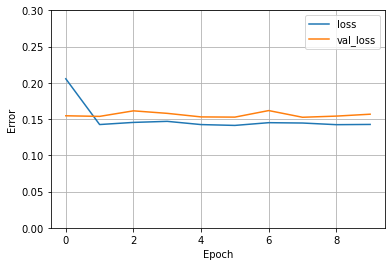

In [18]:
model_2l_10_relu = keras.Sequential([layers.Dense(10, activation='relu'),
                                    layers.Dense(1, activation='linear')])

history_plot(model_2l_10_relu, x_train_mat, y_train_mat, epoch=10)
test_results['2 слоя, 10 нейр., relu'] = model_2l_10_relu.evaluate(x_test_mat,
                                                                         y_test_mat,
                                                                         verbose=0)

#### Модель: 2 сл. с 10 нейр., relu (компоненты)

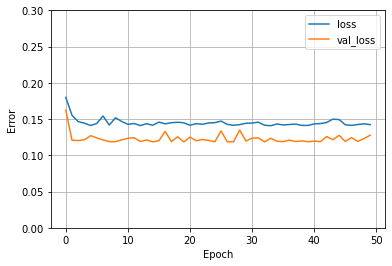

In [19]:
model_2l_10_relu_dec = keras.Sequential([layers.Dense(10, activation='relu'),
                                        layers.Dense(1, activation='linear')])

history_plot(model_2l_10_relu_dec, x_train_decomp, y_train_decomp,epoch=50)
test_results['2 слоя, 10 нейр., relu (компоненты)'] = model_2l_10_relu_dec.evaluate(x_test_decomp,
                                                                                            y_test_decomp,
                                                                                            verbose=0)

#### Модель: 2 сл. 30 нейр., сигмоида

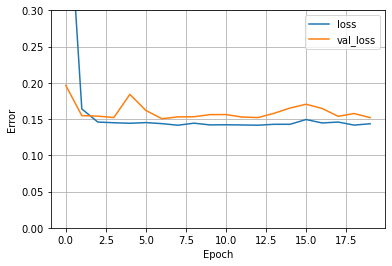

In [20]:
model_2l_30_sigm = keras.Sequential([layers.Dense(30, activation='sigmoid'),
                                    layers.Dense(1, activation='linear')])
  
history_plot(model_2l_30_sigm, x_train_mat, y_train_mat)
test_results['2 слоя, 30 нейр., сигмоида'] = model_2l_30_sigm.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 2 сл. 30 нейр., сигмоида (компоненты)

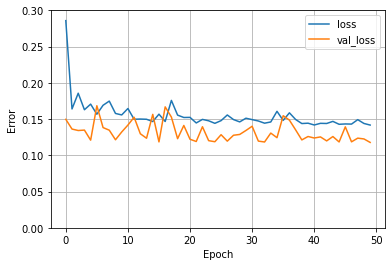

In [21]:
model_2l_30_sigm_dec = keras.Sequential([layers.Dense(30, activation='sigmoid'),
                                        layers.Dense(1, activation='linear')])

history_plot(model_2l_30_sigm_dec, x_train_decomp, y_train_decomp, epoch=50)
test_results['2 слоя, 30 нейр., сигмоида (компоненты)'] = model_2l_30_sigm_dec.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

#### Модель: 1 сл. 30 нейрю, relu

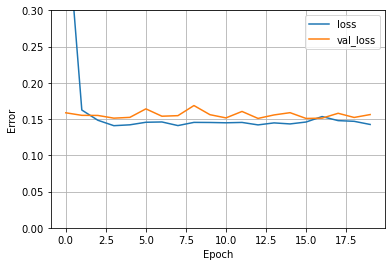

In [22]:
model_2l_30_relu = keras.Sequential([layers.Dense(30, activation='relu'),
                                    layers.Dense(1, activation='linear')])

history_plot(model_2l_30_relu, x_train_mat, y_train_mat)
test_results['2 слоя, 30 нейр., relu'] = model_2l_30_relu.evaluate(x_test_mat,
                                                                         y_test_mat,
                                                                         verbose=0)

#### Модель: 1 сл. 30 нейрю, relu (компоненты)

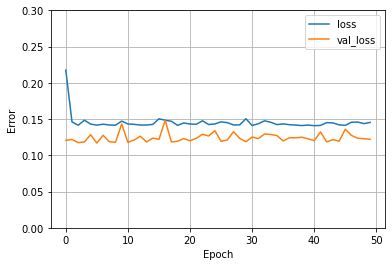

In [23]:
model_2l_30_relu_dec = keras.Sequential([layers.Dense(30, activation='relu'),
                                        layers.Dense(1, activation='linear')])

history_plot(model_2l_30_relu_dec, x_train_decomp, y_train_decomp, epoch=50)
test_results['2 слоя, 30 нейр., relu (компоненты)'] = model_2l_30_relu_dec.evaluate(x_test_decomp,
                                                                                            y_test_decomp,
                                                                                            verbose=0)

#### Модель: 3 сл., 10 нейр., сигмоида

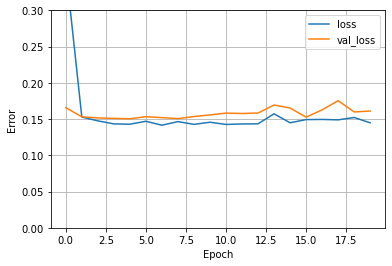

In [24]:
model_3l_10_sigm = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                     layers.Dense(10, activation='sigmoid'),
                                     layers.Dense(1, activation='linear')])
  
history_plot(model_3l_10_sigm, x_train_mat, y_train_mat)
test_results['3 слоя, 10 нейр., сигмоида'] = model_3l_10_sigm.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл., 10 нейр., сигмоида (компоненты)

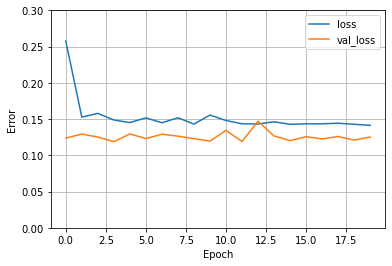

In [25]:
model_3l_10_sigm_dec = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                         layers.Dense(10, activation='sigmoid'),
                                         layers.Dense(1, activation='linear')])

history_plot(model_3l_10_sigm_dec, x_train_decomp, y_train_decomp)
test_results['3 слоя, 10 нейр., сигмоида (компоненты)'] = model_3l_10_sigm_dec.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

#### Модель: 3 сл., 10 нейр., relu

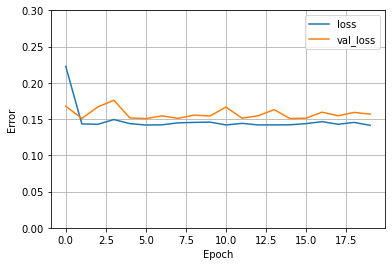

In [26]:
model_3l_10_relu = keras.Sequential([layers.Dense(10, activation='relu'),
                                     layers.Dense(10, activation='relu'),
                                     layers.Dense(1, activation='linear')])
  
history_plot(model_3l_10_relu, x_train_mat, y_train_mat)
test_results['3 слоя, 10 нейр., relu'] = model_3l_10_relu.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл., 10 нейр., relu (компоненты)

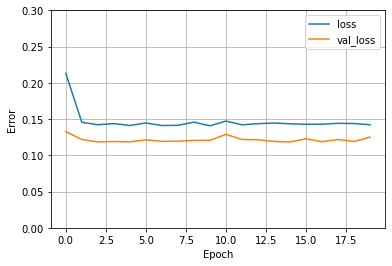

In [27]:
model_3l_10_relu_dec = keras.Sequential([layers.Dense(10, activation='relu'),
                                         layers.Dense(10, activation='relu'),
                                         layers.Dense(1, activation='linear')])

history_plot(model_3l_10_relu_dec, x_train_decomp, y_train_decomp)
test_results['3 слоя, 10 нейр., relu (компоненты)'] = model_3l_10_relu_dec.evaluate(x_test_decomp,
                                                                                            y_test_decomp,
                                                                                            verbose=0)

#### Модель: 3 сл, 30 нейр, сигмоида

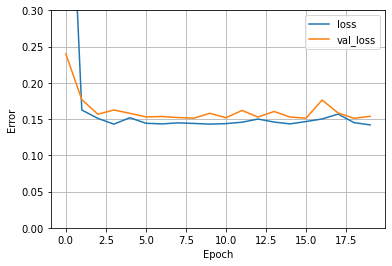

In [28]:
model_3l_30_sigm = keras.Sequential([layers.Dense(30, activation='sigmoid'),
                                     layers.Dense(30, activation='sigmoid'),
                                     layers.Dense(1, activation='linear')])
  
history_plot(model_3l_30_sigm, x_train_mat, y_train_mat)
test_results['3 слоя, 30 нейр., сигмоида'] = model_3l_30_sigm.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл, 30 нейр, сигмоида (компоненты)

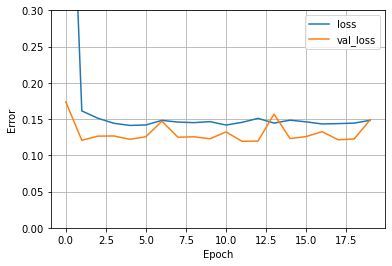

In [29]:
model_3l_30_sigm_dec = keras.Sequential([layers.Dense(30, activation='sigmoid'),
                                         layers.Dense(30, activation='sigmoid'),
                                         layers.Dense(1, activation='linear')])

history_plot(model_3l_30_sigm_dec, x_train_decomp, y_train_decomp)
test_results['3 слоя, 30 нейр., сигмоида (компоненты)'] = model_3l_30_sigm_dec.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

#### Модель: 3 сл, 30 нейр, relu

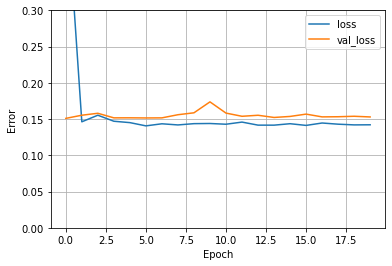

In [30]:
model_3l_30_relu = keras.Sequential([layers.Dense(30, activation='relu'),
                                     layers.Dense(30, activation='relu'),
                                     layers.Dense(1, activation='linear')])
  
history_plot(model_3l_30_relu, x_train_mat, y_train_mat)
test_results['3 слоя, 30 нейр., relu'] = model_3l_30_relu.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл, 30 нейр, relu (компоненты)

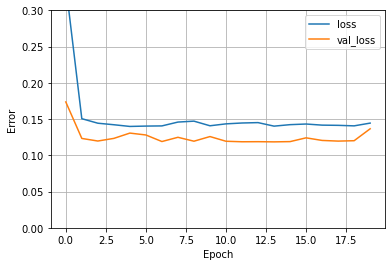

In [31]:
model_3l_30_relu_dec = keras.Sequential([layers.Dense(30, activation='relu'),
                                         layers.Dense(30, activation='relu'),
                                         layers.Dense(1, activation='linear')])

history_plot(model_3l_30_relu_dec, x_train_decomp, y_train_decomp)
test_results['3 слоя, 30 нейр., relu (компоненты)'] = model_3l_30_relu_dec.evaluate(x_test_decomp,
                                                                                            y_test_decomp,
                                                                                            verbose=0)

#### Модель: 3 сл, 10 нейр, сигмоида, dropout слой

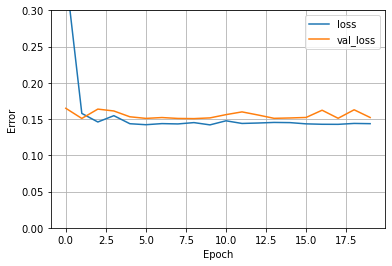

In [32]:
model_3l_10_sigm_drop = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                          layers.Dropout(0.1),
                                          layers.Dense(10, activation='sigmoid'),
                                          layers.Dropout(0.1),
                                          layers.Dense(1, activation='linear')])
  
history_plot(model_3l_10_sigm_drop, x_train_mat, y_train_mat)
test_results['3 слоя, 10 нейр., сигмоида, dropout'] = model_3l_10_sigm_drop.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл, 10 нейр, сигмоида, dropout слой (компоненты)

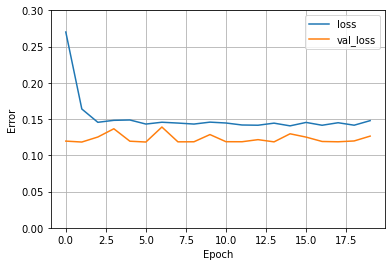

In [33]:
model_3l_10_sigm_dec_drop = keras.Sequential([layers.Dense(10, activation='sigmoid'),
                                              layers.Dropout(0.1),
                                              layers.Dense(10, activation='sigmoid'),
                                              layers.Dropout(0.1),
                                              layers.Dense(1, activation='linear')])

history_plot(model_3l_10_sigm_dec_drop, x_train_decomp, y_train_decomp)
test_results['3 слоя, 30 нейр., сигмоида, dropout (компоненты)'] = model_3l_10_sigm_dec_drop.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

#### Модель: 3 сл, 10 нейр, relu, dropout слой

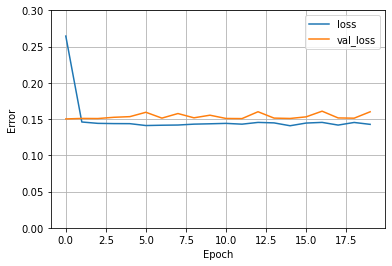

In [34]:
model_3l_10_relu_drop = keras.Sequential([layers.Dense(10, activation='relu'),
                                          layers.Dropout(0.1),
                                          layers.Dense(10, activation='relu'),
                                          layers.Dropout(0.1),
                                          layers.Dense(1, activation='linear')])
  
history_plot(model_3l_10_relu_drop, x_train_mat, y_train_mat)
test_results['3 слоя, 10 нейр., relu, dropout'] = model_3l_10_relu_drop.evaluate(x_test_mat,
                                                                            y_test_mat,
                                                                            verbose=0)

#### Модель: 3 сл, 10 нейр, relu, dropout слой (компоненты)

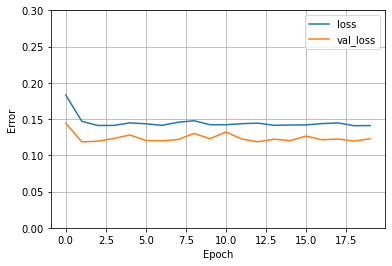

In [35]:
model_3l_10_relu_dec_drop = keras.Sequential([layers.Dense(10, activation='relu'),
                                              layers.Dropout(0.1),
                                              layers.Dense(10, activation='relu'),
                                              layers.Dropout(0.1),
                                              layers.Dense(1, activation='linear')])

history_plot(model_3l_10_relu_dec_drop, x_train_decomp, y_train_decomp)
test_results['3 слоя, 30 нейр., relu, dropout (компоненты)'] = model_3l_10_relu_dec_drop.evaluate(x_test_decomp,
                                                                                                y_test_decomp,
                                                                                                verbose=0)

# Сводная таблица ошибок

In [36]:
pd.DataFrame(test_results, index=['Mean Absolute Error']).T.round(3)

,Mean Absolute Error
"Поверхностная_плотность, 1 слой",0.135
"Линейная модель, 1 слой",0.203
"Линейная модель, 1 слой (компоненты)",0.146
"Поверхностная_плотность, 2 слоя",0.143
"2 слоя, 10 нейр., сигмоида",0.135
"2 слоя, 10 нейр., сигмоида (компоненты)",0.143
"2 слоя, 10 нейр., relu",0.137
"2 слоя, 10 нейр., relu (компоненты)",0.144
"2 слоя, 30 нейр., сигмоида",0.136
"2 слоя, 30 нейр., сигмоида (компоненты)",0.143
